<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/individualevent_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and unzip the relevant GCP data

In [32]:
# See https://global-mind.org/valentines.09.html for a description of the event
#grab the data - uncomment as needed

! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2011/basketdata-2011-09-21.csv.gz -O test.csv.gz

will be placed in the single file you specified.

for details.

--2023-10-31 03:33:50--  https://global-mind.org/data/eggsummary/2011/basketdata-2011-09-21.csv.gz
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5535572 (5.3M) [application/x-gzip]
Saving to: ‘test.csv.gz’

test.csv.gz         100%[===================>]   5.28M   125KB/s    in 43s     

2023-10-31 03:34:34 (125 KB/s) - ‘test.csv.gz’ saved [5535572/5535572]

FINISHED --2023-10-31 03:34:34--
Total wall clock time: 43s
Downloaded: 1 files, 5.3M in 43s (125 KB/s)


In [41]:
#unzip the data - uncomment as needed
!gunzip test.csv.gz

gzip: test.csv.gz: No such file or directory


Ingest the data and compute the chi-squared-minus-1 statistic for each second

In [42]:
#read in all the data

import pandas
eggdata_test = pandas.read_csv("test.csv", skiprows=8)

Average number of RNGs reporting: 64.45074074074074
csm1 z-score (cdf mapping): 3.1348047339234046
csm1 z-score (normal approx): 3.148966694327055


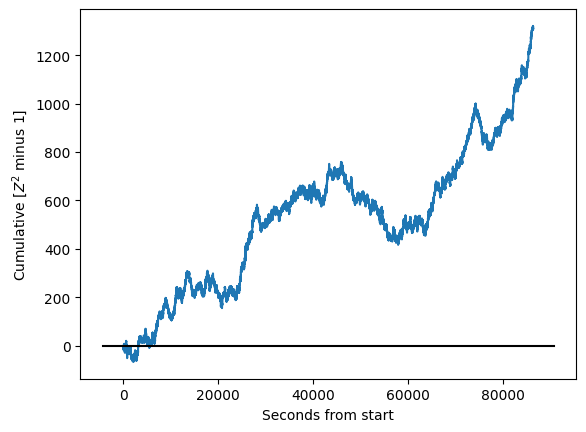

In [78]:
import numpy as np


def get_chisquareminus1(eggdata):
  egg_values = np.array(eggdata.iloc[:, 3:])
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  print("Average number of RNGs reporting:", np.mean(num_nonnan_eggs))
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

#get the chisquare minus stat for the test and controls
csm1_test, compositez_test = get_chisquareminus1(eggdata_test)

print("csm1 z-score (cdf mapping):", scipy.stats.norm.ppf(scipy.stats.chi2(df=len(csm1_test)).cdf(np.sum(csm1_test)+len(csm1_test))) )
print("csm1 z-score (normal approx):", np.sum(csm1_test)/np.sqrt(2*len(csm1_test)))
plt.plot(np.cumsum(csm1_test))
plt.plot(plt.xlim(), [0,0], color="black")
plt.ylabel("Cumulative [$Z^2$ minus 1]")
plt.xlabel("Seconds from start")
plt.show()

With blocksize 2
chi2cdf to z score: 2.3634195838462944
permutation p-value (unadjusted): 0.021


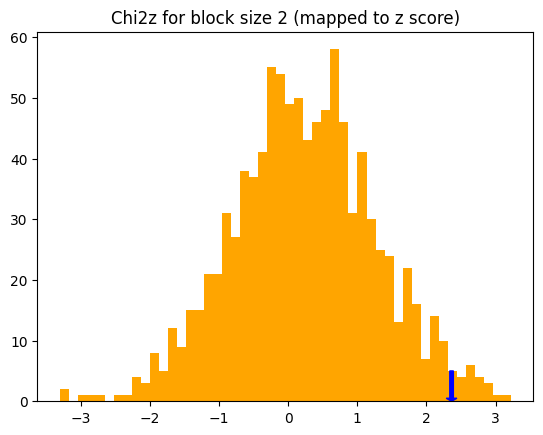

In [79]:
def chi2z_arr(arr, blocksize):
  block_zs = np.sum(arr[0:(len(arr)-(len(arr)%blocksize))].reshape(-1,blocksize), axis=-1)/np.sqrt(blocksize)
  cdf_block_chi2 = scipy.stats.chi2.cdf(x=np.sum(np.square(block_zs)), df=len(block_zs))
  return scipy.stats.norm.ppf(cdf_block_chi2)

def chi2z_arrs(arrs, blocksize):
  block_zs = np.sum(arrs[:,0:(len(arrs)-(len(arrs)%blocksize))].reshape(
      len(arrs),-1,blocksize), axis=-1)/np.sqrt(blocksize)
  cdfs_block_chi2 = scipy.stats.chi2.cdf(
      x=np.sum(np.square(block_zs), axis=-1), df=block_zs.shape[-1])
  return scipy.stats.norm.ppf(cdfs_block_chi2)

blocksize=2
chi2z_test = chi2z_arr(compositez_test, blocksize)
rng = np.random.RandomState(1234)
permute_compositez_test = np.array([rng.permutation(compositez_test)
                                    for i in range(1000)])
chi2z_permutetest = chi2z_arrs(permute_compositez_test, blocksize)

print("With blocksize",blocksize)
print("chi2cdf to z score:", chi2z_test)
print("permutation p-value (unadjusted):", np.mean(chi2z_permutetest >= chi2z_test))
plt.hist(chi2z_permutetest, bins=50, color="orange")
plt.arrow(chi2z_test, 5, 0, -5, color="blue", head_length=0.5, length_includes_head=True, width=np.std(chi2z_permutetest)/20)
plt.title("Chi2z for block size "+str(blocksize)+" (mapped to z score)")
plt.show()


In [45]:
arr = compositez_test
block_zs_reshaped = arr[0:(len(arr)-(len(arr)%blocksize))].reshape(-1,blocksize)

Correlation between index%2==0 and index%2==1: PearsonRResult(statistic=0.0010007221491830126, pvalue=0.41761829935040334)


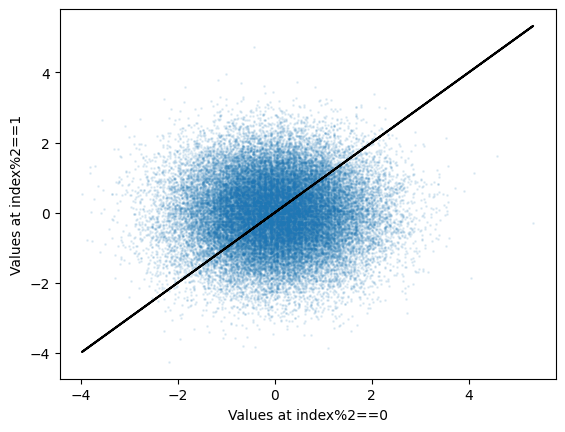

block2 chi-squared test z score (normal approx) 2.3738159372350087


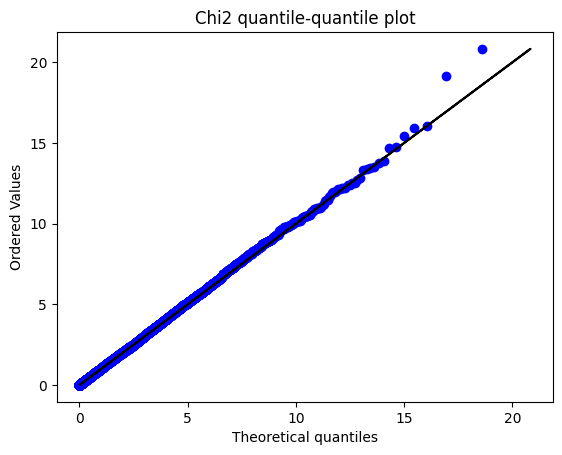

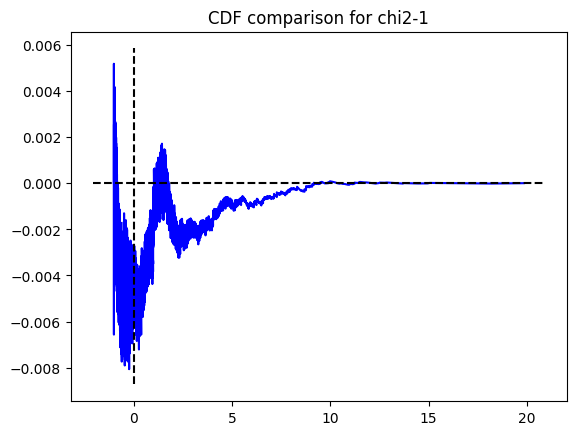

In [70]:
print("Correlation between index%2==0 and index%2==1:",
      scipy.stats.pearsonr(block_zs_reshaped[:,0], block_zs_reshaped[:,1], alternative="greater"))
plt.scatter(block_zs_reshaped[:,0],block_zs_reshaped[:,1],alpha=0.1,s=1)
plt.plot(block_zs_reshaped[:,0], block_zs_reshaped[:,0], color="black")
plt.xlabel("Values at index%2==0"); plt.ylabel("Values at index%2==1")
plt.show()

block_zs_sumz = np.sum(block_zs_reshaped, axis=-1)/np.sqrt(2)
print("block2 chi-squared test z score (normal approx)", np.sum(np.square(block_zs_sumz)-1)/np.sqrt(2*len(block_zs_sumz)))
theoretical_quantiles, ordered_responses = scipy.stats.probplot(np.square(block_zs_sumz), plot=plt, dist=scipy.stats.chi2(df=1), fit=False)
plt.title("Chi2 quantile-quantile plot")
plt.plot(np.square(block_zs_sumz), np.square(block_zs_sumz), color="black")
plt.show()

plt.title("CDF comparison for chi2-1")
plt.plot(ordered_responses-1, ((np.arange(len(ordered_responses))+1)/len(ordered_responses))
                            - scipy.stats.chi2(df=1).cdf(ordered_responses), color="blue")
plt.plot(plt.xlim(), [0,0], color="black", linestyle="--")
plt.plot([0,0], plt.ylim(), color="black", linestyle="--")
plt.show()